## Importing important libraries

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import datetime
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

## Reading csv file

In [2]:
df=pd.read_csv('/content/with_augmentation_2.csv')

## Splitting the data into train and test

In [3]:
train, validation = train_test_split(df, test_size=0.05, random_state = 859)
train, test = train_test_split(train, test_size=0.05, random_state = 859)
print(f"Shape of Training set: {train.shape}")
print(f"Shape of Validation set: {validation.shape}")
print(f"Shape of Test set: {test.shape}")

Shape of Training set: (10830, 3)
Shape of Validation set: (600, 3)
Shape of Test set: (570, 3)


In [4]:
train.iloc[0]['informal_text_inp']= str(train.iloc[0]['informal_text_inp'])+'>'
train.iloc[0]['normal_text_inp']= str(train.iloc[0]['normal_text_inp'])+'>'

## Creating tokens of characters

In [5]:
#refrence taken from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tknizer_informal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
tknizer_informal.fit_on_texts(train['informal_text_inp'].values)
tknizer_normal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
tknizer_normal.fit_on_texts(train['normal_text_inp'].values)

In [6]:
#refrence taken from https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
vocab_size_informal=len(tknizer_informal.word_index.keys())
print('vocab size of informal texts are:',vocab_size_informal)
vocab_size_normal=len(tknizer_normal.word_index.keys())
print('vocab size of normal texts are:',vocab_size_normal)

vocab size of informal texts are: 142
vocab size of normal texts are: 92


## Defining loss function

In [7]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## Loading our best model

In [8]:
model = tf.keras.models.load_model('Model_concat', custom_objects={"loss_function": loss_function})

In [9]:
UNITS = 200
MAX_LEN = 200

## Prediction of 10 sentences from the start of test data set

In [10]:
def predict(input_sentence, model):
    inputs = [tknizer_informal.word_index.get(i, 0) for i in input_sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = MAX_LEN, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    UNITS=200
    hidden = tf.zeros([1, UNITS]), tf.zeros([1, UNITS])
    enc_out, state_h, state_c = model.encoder([inputs, hidden])
    dec_hidden = [state_h, state_c]
    dec_input = tf.expand_dims([tknizer_normal.word_index['<']], 0)
    for t in range(MAX_LEN):
        output, state_h, state_c = model.decoder.timestepdecoder([dec_input, enc_out, state_h, state_c])
        predicted_id = tf.argmax(output[0]).numpy()
        if tknizer_normal.index_word.get(predicted_id, '') == '>':
            break
        else:
            result += tknizer_normal.index_word.get(predicted_id, '')
            dec_input = tf.expand_dims([predicted_id], 0)
    return result

In [11]:
for i in range(10):
    sentence=test['informal_text_inp'].iloc[i]
    predicted_sentence = predict(sentence,model)
    print('Input sentene :',test['informal_text_inp'].iloc[i])
    print('Predicted sentence: ',''.join(x for x in predicted_sentence))
    print('original Sentence :',test['normal_text_out'].iloc[i])
    print('*'*100)

Input sentene : <Watche Just Married. Haha.>
Predicted sentence:  Watch Just Married. Haha.
original Sentence : Watch Just Married. Haha.>
****************************************************************************************************
Input sentene : <No problem, control you again presently.>
Predicted sentence:  No problem, so I decidency.
original Sentence : No problem, see you again soon.>
****************************************************************************************************
Input sentene : <LOOOL, kidding. Reevaluate already. Overprotective like actually. May I ask you? Must i think I should ripped fringe short?>
Predicted sentence:  Langer I have already. Overploised people stule is like attally. Month is all table?
original Sentence : Haha, okay. Understand already. Overprotective like that. May I ask you? Do you think I should cut fringe short?>
****************************************************************************************************
Input sentene :

## Calculating bleu score fro each sentence in test dataset

In [12]:
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
import random
from tqdm.auto import tqdm
score =[]
for i in tqdm(range(test.shape[0])):
    #a=random.randint(1,len(test))
    translation= predict(test['informal_text_inp'].iloc[i],model)
    translation=translation.split()
    reference = test['normal_text_out'].iloc[i].split()
    score.append(bleu.sentence_bleu([reference], translation))

  0%|          | 0/570 [00:00<?, ?it/s]

# EXPLORATORY DATA ANALYSIS POST TRAINING 

## 1.Distribution plot of bleu score over test dataset

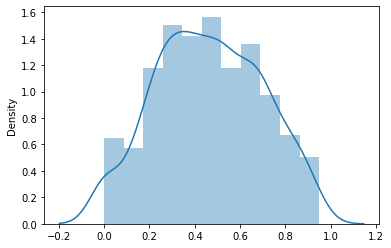

In [13]:
import seaborn as sns
sns.distplot(score)

In [14]:
print(np.max(score))
print(np.min(score))
print(np.mean(score))

0.948543837069451
0.0
0.4627147470492333


## Inference
We can see that bleu score is kind of following normal distributionplot  and important insights that we can observe are:

    1.Maximum value of bleu score is 0.948543837069451
    2.Minimum value of bleu score is 0.0
    3.Average value of bleu score is 0.4627147470492333

## 2.Finding relation between sentence length and bleu score of predicted sentence

In [30]:
sentence_length=test['informal_text_inp'].str.split().apply(len)
d = {'sentence_length': sentence_length, 'bleu_score': score}
df = pd.DataFrame(data=d)
df.reset_index(inplace=True,drop=True)

In [31]:
df[df['bleu_score']>.93][:5]

,sentence_length,bleu_score
113,20,0.942615
169,22,0.945742
172,37,0.934335
273,23,0.948544
287,19,0.935133


In [35]:
df[df['bleu_score']>.5][:5]

,sentence_length,bleu_score
0,4,0.707107
3,20,0.524532
5,8,0.840896
6,11,0.893154
7,10,0.549778


In [40]:
df[df['bleu_score']==0][:5]

,sentence_length,bleu_score
53,9,0.0
62,4,0.0
75,5,0.0
81,2,0.0
87,5,0.0


In [46]:
print('Average sentence length for best bleu score   :',np.mean(df[df['bleu_score']>.93]['sentence_length']))
print('Average sentence length for medium bleu score :',np.mean(df[df['bleu_score']>.5]['sentence_length']))
print('Average sentence length for worst bleu score  :',np.mean(df[df['bleu_score']==0]['sentence_length']))

Average sentence length for best bleu score   : 24.2
Average sentence length for medium bleu score : 11.102766798418973
Average sentence length for worst bleu score  : 5.333333333333333


### Inference
 We can see that as the sentence length is increasing bleu score is increasing ,for sentences with lesser number of characters we are getting low bleu score

## We will print prediction of  5 sentences of  best bleu score ,5 sentences of medium bleu score  and 5 sentences of worst bleu score 

### 5 sentences having best bleu score

In [15]:
for i,j in enumerate(score):
  if j>0.93:
    sentence=test['informal_text_inp'].iloc[i]
    predicted_sentence = predict(sentence,model)
    print('Input sentene :',test['informal_text_inp'].iloc[i])
    print('Predicted sentence: ',''.join(x for x in predicted_sentence))
    print('original Sentence :',test['normal_text_out'].iloc[i])
    print('*'*100)

Input sentene : <Sharis, Gen asks if we need to meet up today. Are you free? Please respond as before long as possible.>
Predicted sentence:  Sharis, Gen asks if we want to meet up today. Are you free? Please reply as soon as possible.
original Sentence : Sharis, Gen asks if we want to meet up today. Are you free? Please reply as soon as possible.>
****************************************************************************************************
Input sentene : <Hectometer. Yes, I don ' t mind going, but she vocalize like she really needs to sell the ticket. Be you going?>
Predicted sentence:  Hm. Yes, I don't mind going, but she sounds like she really needs to sell the tickets. Are you going?
original Sentence : Hm. Yes, I don't mind going, but she sounds like she really needs to sell the tickets. Are you going?>
****************************************************************************************************
Input sentene : <You ' ve got tuition in the afternoon. Ok. Haha, my si

### 5 sentences having medium bleu score

In [17]:
c=0
for i,j in enumerate(score):
  if j>0.5 and j<0.51:
    c=c+1
    if c<6:
      sentence=test['informal_text_inp'].iloc[i]
      predicted_sentence = predict(sentence,model)
      print('Input sentene :',test['informal_text_inp'].iloc[i])
      print('Predicted sentence: ',''.join(x for x in predicted_sentence))
      print('original Sentence :',test['normal_text_out'].iloc[i])
      print('*'*100)

Input sentene : <Hi! Can editors chat?>
Predicted sentence:  Hi! Can interest you coming topics?
original Sentence : Hi! Can we chat?>
****************************************************************************************************
Input sentene : <Haha. Ok. Likely Borburn Coke?>
Predicted sentence:  Haha. Ok. Sigh. Look in 2nd?
original Sentence : Haha. Ok. Probably Borburn Coke?>
****************************************************************************************************
Input sentene : <Yes. I own ' t forgert you. Naw have to help Xin chop one more sit, I began the chooping girl aleady.>
Predicted sentence:  Yes. I apply there are you. Now have to help Xin chop one more seat, I belated the choose because of SART.
original Sentence : Yes. I won't forget you. Now have to help Xin chop one more seat, I became the chopping girl already.>
****************************************************************************************************
Input sentene : <Two: Thirty then. Whe

### 5 sentences having worst bleu score

In [18]:
c=0
for i,j in enumerate(score):
  if j==0:
    c=c+1
    if c<6:
      sentence=test['informal_text_inp'].iloc[i]
      predicted_sentence = predict(sentence,model)
      print('Input sentene :',test['informal_text_inp'].iloc[i])
      print('Predicted sentence: ',''.join(x for x in predicted_sentence))
      print('original Sentence :',test['normal_text_out'].iloc[i])
      print('*'*100)

Input sentene : <Hatchet man hi! you sape nama? boleh kite chat?>
Predicted sentence:  Have next man up to call at home? What time and have boxere chat?
original Sentence : Iceman hi! you sape nama? boleh kite chat?>
****************************************************************************************************
Input sentene : <Sweep and playing games.>
Predicted sentence:  Sailes. Think anything get.
original Sentence : Sailing and playing games.>
****************************************************************************************************
Input sentene : <bakshis, WHAT arR yoU DOING?>
Predicted sentence:  Not arrang Millian, you don't you?
original Sentence : TIP,WHAT arR yoU DOING ?>
****************************************************************************************************
Input sentene : <Clearly no.>
Predicted sentence:  Call now.
original Sentence : No no.>
****************************************************************************************************
I

# Analysis based on prediction of best ,medium and worst bleu score sentences

1.Sentences having best bleu score are very less punctuations or capital and small characters combinations

    ex:

    Predicted sentence:  Sharis, Gen asks if we want to meet up today. Are you free? Please reply as soon as possible.
    original Sentence : Sharis, Gen asks if we want to meet up today. Are you free? Please reply as soon as possible.

2.Sentences having medium  bleu score are some  punctuations or alpha numeric  combinations

    ex:

    Predicted sentence:  Today then. Where will you be?
    original Sentence : 2:30 then. Where will you be?>

3.Sentences having worst  bleu score are many punctuations or combinations of uppercase and lower case characters or alpha numeric combinations.

    ex:
    Predicted sentence:  Not arrang Millian, you don't you?
    original Sentence : TIP,WHAT arR yoU DOING ?>

# CONCLUSION
1.As we have very less amount of data only 2k .So,it is very difficult for any complex model also to learn the pattern and give good bleu score .

2.We have done data augmenation and made data to 12k from 2k with relevant augmenation technique like model based word augmenation,synonym augmentation ,spelling augmentation and after that we are able to achieve this much accuracy in prediction to improve it further we have to take larger dataset for sentence correction like GYAFC corpus.